In [1]:
from datetime import datetime
import json
import string
import nltk
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta

%matplotlib inline

class Config:
    def __init__(self):
        pass


def set_config(config_dict):
    config = Config()
    config.__dict__ = config_dict
    return config


In [2]:
config = set_config({
    'row_start': '2004-10-16',
    'row_end': '2004-12-14',
    "timestep": 2,
    "max_batch_size": 1,
    "layer_size": 2,
    "unit_size": 4,
    "dropout": 0,
    "learning_rate": 0.01,
    "max_epoch": 100,
    "time_col": 'tanggal',
    "num_predict": 5,
    # "feature": ['rr'],
    # "feature": ['tn','tx','tavg','rh_avg','rr','ss','ff_x','ddd_x','ff_avg','ddd_car'],
    "feature": ['rh_avg'],
    # "prediction": 'rr'
    "prediction": 'rh_avg'
})


def train_test_split(dataset, timestep=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - timestep):
        dataX.append(dataset[i:(i + timestep)])
        dataY.append(dataset[i + timestep:i+timestep+1])
    return np.array(dataX), np.array(dataY)

def proyeksi_split(dataset, timestep=1):
    dataX = []
    for i in range(len(dataset) - timestep + 1):
        dataX.append(dataset[i:(i + timestep)])
    return np.array(dataX)

In [3]:
DATASETS = pd.read_csv('../Data/1985-2021.csv').replace(to_replace=[8888, 9999, 2555], value=np.nan)
DATASETS.interpolate(inplace=True)

for feature in DATASETS:
  if DATASETS[feature].dtypes == object and feature != config.time_col:
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1)
    tokenizer.fit_on_texts(DATASETS[feature].astype(str))
    index_word = list(tokenizer.index_word.values())
    word_index = list(tokenizer.word_index.values())
    
    for index in index_word:
      DATASETS = DATASETS.replace(to_replace=str(index.upper()), value=tokenizer.word_index[index], regex=True)
      
DATASETS = DATASETS.loc[
  (DATASETS[config.time_col] >= config.row_start) & (DATASETS[config.time_col] <= config.row_end)
]

DATELIST = np.array([datetime.strptime(date, '%Y-%m-%d').date() for date in list(DATASETS[config.time_col])])

In [4]:
featuresets = DATASETS[config.feature]

scaller = MinMaxScaler()
featuresets_scaled = scaller.fit_transform(featuresets)

train_size = int(featuresets_scaled.shape[0] * 0.9)
trainset, testset = featuresets_scaled[0:train_size], featuresets_scaled[train_size:featuresets_scaled.shape[0]]
traindateset, testdateset = DATELIST[0:train_size], DATELIST[train_size:DATELIST.size]

X_train, y_train = train_test_split(trainset, timestep=config.timestep)
X_train = np.reshape(X_train, (X_train.shape[0], len(config.feature), X_train.shape[1]))
y_train = np.reshape(y_train, (y_train.shape[0], len(config.feature), y_train.shape[1]))

In [5]:
# y_pred_loss = list()
# y_true_loss = list()
# loss = list()


def mean_squared_error(y_true, y_pred):
    # y_pred_loss.append(y_pred)
    # y_true_loss.append(y_true)
    # loss.append(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))
    return tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true))


def root_mean_squared_error(y_true, y_pred):
    return tf.keras.backend.sqrt(mean_squared_error(y_pred, y_true))

model = tf.keras.models.Sequential()

for i in range(0, config.layer_size):
    model.add(
        tf.keras.layers.LSTM(
            units=config.unit_size,
            # return_sequences=False if i == config.layer_size - 1 else True,
            return_sequences=True,
            batch_input_shape=(config.max_batch_size, len(config.feature), config.timestep),
            go_backwards=True,
            # weights=[
            #     np.array([
            #         [0.5774, 0.5774, 0.5774, 0.5774],
            #         [0.5774, 0.5774, 0.5774, 0.5774]
            #     ]),
            #     np.array([
            #         [0.5774, 0.5774, 0.5774, 0.5774]
            #     ]),
            #     np.zeros([4])
            # ]
        )
    )
else:
    model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=config.learning_rate),
        loss=mean_squared_error,
        run_eagerly=True
    )
    model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, 1, 4)                 112       
                                                                 
 lstm_1 (LSTM)               (1, 1, 4)                 144       
                                                                 
Total params: 256
Trainable params: 256
Non-trainable params: 0
_________________________________________________________________


In [6]:
# from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

batch_loss = list()


history = model.fit(
    X_train,
    y_train,
    shuffle=False,
    epochs=config.max_epoch,
    verbose=1,
    batch_size=config.max_batch_size,
    callbacks=[
        tf.keras.callbacks.LambdaCallback(
            on_epoch_begin=None,
            on_epoch_end=None,
            on_batch_begin=None,
            on_batch_end=lambda batch, logs=None: batch_loss.append(logs['loss']),
            on_train_begin=None,
            on_train_end=None,
        )
    ]
)

Epoch 1/100
52/52 [==============================] - 4s 65ms/step - loss: 0.3987
Epoch 2/100
52/52 [==============================] - 6s 113ms/step - loss: 0.3868
Epoch 3/100
52/52 [==============================] - 6s 124ms/step - loss: 0.3752
Epoch 4/100
52/52 [==============================] - 9s 166ms/step - loss: 0.3642
Epoch 5/100
52/52 [==============================] - 8s 160ms/step - loss: 0.3537
Epoch 6/100
52/52 [==============================] - 5s 96ms/step - loss: 0.3436
Epoch 7/100
52/52 [==============================] - 5s 87ms/step - loss: 0.3340
Epoch 8/100
52/52 [==============================] - 7s 125ms/step - loss: 0.3250
Epoch 9/100
52/52 [==============================] - 7s 128ms/step - loss: 0.3163
Epoch 10/100
52/52 [==============================] - 7s 136ms/step - loss: 0.3082
Epoch 11/100
52/52 [==============================] - 9s 170ms/step - loss: 0.3004
Epoch 12/100
52/52 [==============================] - 5s 94ms/step - loss: 0.2931
Epoch 13/100
52/5

In [7]:
X_test, y_test = train_test_split(testset, timestep=config.timestep)
X_test = np.reshape(X_test, (X_test.shape[0], len(config.feature), X_test.shape[1]))
y_test = np.reshape(y_test, (y_test.shape[0], len(config.feature), y_test.shape[1]))

results = model.evaluate(
    X_test,
    y_test,
    verbose=1,
    batch_size=config.max_batch_size,
)

4/4 [==============================] - 0s 31ms/step - loss: 0.0659


In [8]:
testset_split = proyeksi_split(testset, timestep=config.timestep)
testset_split_reshape = np.reshape(testset_split, (testset_split.shape[0], len(config.feature), testset_split.shape[1]))
proyeksi = model.predict(testset_split_reshape, verbose=1, batch_size=1)
for i in range(0, proyeksi.shape[0]):
    testset[i + config.timestep - 1] = np.reshape(proyeksi[i], (proyeksi[i].shape[1], len(config.feature)))

5/5 [==============================] - 0s 22ms/step


ValueError: could not broadcast input array from shape (4,1) into shape (1,)

In [ ]:
for i in range(0, config.num_predict):
    testset_split = proyeksi_split(testset, timestep=config.timestep)
    testset_split_reshape = np.reshape(testset_split, (testset_split.shape[0], len(config.feature), testset_split.shape[1]))
    proyeksi = model.predict(testset_split_reshape, batch_size=1)
    testset = np.concatenate((testset, np.reshape(proyeksi[-1], (proyeksi[-1].shape[1], len(config.feature)))), axis=0)

9/9 [==============================] - 0s 24ms/step


In [ ]:
testset = scaller.inverse_transform(testset)
testdateset = np.concatenate((testdateset, pd.to_datetime(pd.date_range(DATELIST[-1] + timedelta(days=1), periods=config.num_predict, freq='1d')).date), axis=0)

LABEL = np.concatenate((traindateset, testdateset), axis=0)

PREDICTIONS = pd.DataFrame(testset, columns=[config.feature]).set_index(pd.Series(testdateset))
PREDICTIONS.index = PREDICTIONS.index.to_series().apply(lambda x: datetime.strptime(x.strftime('%Y-%m-%d'), '%Y-%m-%d'))

HISTORY = pd.DataFrame(np.array(DATASETS[config.feature]), columns=[config.feature]).set_index(pd.Series(DATELIST))
HISTORY.index = HISTORY.index.to_series().apply(lambda x: datetime.strptime(x.strftime('%Y-%m-%d'), '%Y-%m-%d'))

START_DATE_FOR_PLOTTING = (DATELIST[-1] - timedelta(days=max((config.num_predict) * 3, 90))).strftime("%Y-%m-%d")
blank_index = (DATELIST[-(DATASETS.shape[0] - train_size + config.timestep - 1)]).strftime("%Y-%m-%d")

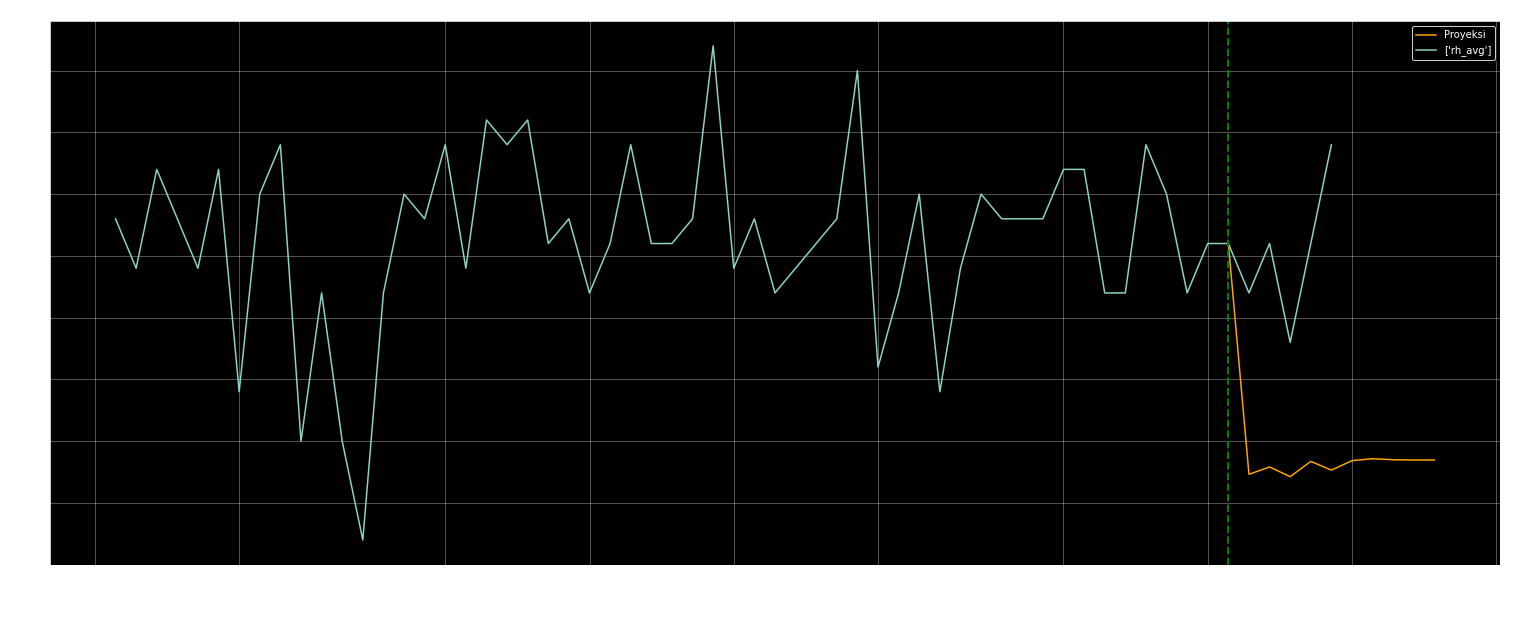

In [ ]:
from pylab import rcParams

rcParams['figure.figsize'] = 26, 10

plt.plot(PREDICTIONS.loc[START_DATE_FOR_PLOTTING:].index, PREDICTIONS.loc[START_DATE_FOR_PLOTTING:][config.prediction], color='orange', label='Proyeksi')
plt.plot(HISTORY.loc[START_DATE_FOR_PLOTTING:].index, HISTORY.loc[START_DATE_FOR_PLOTTING:][config.feature], label=config.feature)

plt.axvline(x = min(PREDICTIONS.index), color='green', linewidth=2, linestyle='--')
plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.title('Prediksi dan Histori Curah Hujan', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Tingkat Nilai', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.legend(shadow=True)
plt.show()